<a href="https://colab.research.google.com/github/kirmel4/BurgerMenuWebApp/blob/main/BurgerMenuDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random

from tqdm.auto import tqdm
import shutil as sh
from PIL import Image

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
train_dir = "/content/gdrive/MyDrive/DataSets/train"
test_dir = "/content/gdrive/MyDrive/DataSets/test"


In [ ]:
print('Image(train): ', len(os.listdir(train_dir)))
print('Image(test): ', len(os.listdir(test_dir)))

Image(train):  78
Image(test):  9


In [ ]:
from pathlib import Path

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5
!pip install -r ./yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15287, done.
remote: Total 15287 (delta 0), reused 0 (delta 0), pack-reused 15287
Receiving objects: 100% (15287/15287), 14.18 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (10483/10483), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/DataSets/labels_my-project-name_2023-03-05-02-17-59.csv')

In [ ]:
data

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,burgermenu,7,133,29,30,0YgW05Ba7n4.jpg,499,1080
1,burgermenu,439,140,43,43,6M8q7bDv688.jpg,499,1080
2,burgermenu,452,138,39,28,CCIgib8C7O8.jpg,499,1080
3,burgermenu,10,273,53,39,CO_YW2MllqY.jpg,499,1080
4,burgermenu,16,132,40,40,D3vwMh9CakE.jpg,499,1080
...,...,...,...,...,...,...,...,...
73,burgermenu,524,160,47,40,photo_9_2023-03-05_14-06-22.jpg,591,1280
74,burgermenu,16,455,36,31,photo_9_2023-03-05_14-06-36.jpg,591,1280
75,burgermenu,373,242,26,28,tRMVw8Ye4vw.jpg,499,1080
76,burgermenu,441,927,42,37,wP0dkq32cK4.jpg,499,1080


In [ ]:
data['xmin'] = data['bbox_x']
data['xmax'] = data['bbox_x'] + data['bbox_width']
data['ymin'] = data['bbox_y']
data['ymax'] = data['bbox_y'] + data['bbox_height']

In [ ]:
im_h, im_w, num_chanels = (1280, 591, 3)
data["x_center"] = (data["xmax"] + data["xmin"])/2
data["y_center"] = (data["ymax"] + data["ymin"])/2
data["w"] = data["xmax"] - data["xmin"]
data["h"] = data["ymax"] - data["ymin"]
data["classes"] = 0
#Normalizing the values with image height and width
data["x_center"] = data["x_center"]/im_w
data["w"] = data["w"]/im_w
data["y_center"] = data["y_center"]/im_h
data["h"] = data["h"]/im_h
data['image'] = data['image_name']
data.drop(['label_name','image_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_width', 'image_height'], axis =1, inplace =True)
data.head()

,xmin,xmax,ymin,ymax,x_center,y_center,w,h,classes,image
0,7,36,133,163,0.036379,0.115625,0.049069,0.023438,0,0YgW05Ba7n4.jpg
1,439,482,140,183,0.779188,0.126172,0.072758,0.033594,0,6M8q7bDv688.jpg
2,452,491,138,166,0.797800,0.118750,0.065990,0.021875,0,CCIgib8C7O8.jpg
3,10,63,273,312,0.061760,0.228516,0.089679,0.030469,0,CO_YW2MllqY.jpg
4,16,56,132,172,0.060914,0.118750,0.067682,0.031250,0,D3vwMh9CakE.jpg


In [ ]:
IMAGE_SHAPE = 0
for i in range(1):
  for files in os.listdir(train_dir):
    image = plt.imread(train_dir +'/'+ files)
    plt.figure()
    plt.imshow(image)
    IMAGE_SHAPE = image.shape
    print(image.shape)
    point1 = (int(data[data['image'] == files].xmin), int(data[data['image'] == files].ymin))
    point2 = (int(data[data['image'] == files].xmax), int(data[data['image'] == files].ymax))
    cv2.rectangle(image, point1, point2, color=(0, 255, 0), thickness=3)
    plt.figure()
    plt.imshow(image)

In [ ]:
index = list(data.image)

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")
    os.makedirs("data/fold{}".format(0))

In [ ]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(data.groupby('image')):
            if name in val_index:
                path2save = 'val/'
            else:
                path2save = 'train/'
            if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
            with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/gdrive/MyDrive/DataSets/{}/{}".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))
        print("Copy done")
        print('Image(train): ', len(os.listdir('data/fold0/images/train/')))
        print('Image(test): ', len(os.listdir('data/fold0/images/val/')))

  0%|          | 0/78 [00:00<?, ?it/s]

Copy done
Image(train):  63
Image(test):  15


In [ ]:
%%writefile dataset.yaml
path: /content/data/fold0
train: /content/data/fold0/images/train
val: /content/data/fold0/images/val
test: /content/gdrive/MyDrive/DataSets/test

names:
    0: burgermenu

Writing dataset.yaml


In [ ]:
import time

start = time.perf_counter()

!python yolov5/train.py --batch 2 --epochs 60 --data dataset.yaml --weights {MODEL} --name my_model_5x

end = time.perf_counter()

total_time = end - start

print(f'Training time for {MODEL} model is: {total_time:0.2f} seconds')

train: weights=yolov5x.pt, cfg=, data=dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=my_model_5x, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, 

In [ ]:
!ls yolov5/runs/train/my_model_5x8/

confusion_matrix.png				     train_batch1.jpg
events.out.tfevents.1678005651.29ebc1b3ddbd.23100.0  train_batch2.jpg
hyp.yaml					     val_batch0_labels.jpg
labels_correlogram.jpg				     val_batch0_pred.jpg
labels.jpg					     val_batch1_labels.jpg
opt.yaml					     val_batch1_pred.jpg
results.csv					     val_batch2_labels.jpg
results.png					     val_batch2_pred.jpg
train_batch0.jpg				     weights


In [ ]:
Image.open("yolov5/runs/train/my_model_5x10/F1_curve.png")

In [ ]:
IMG_SIZE = 1280
CONF_TRESHOLD = 0.17
IOU_THRESHOLD = 0.5
MODEL = 'yolov5x.pt'

In [ ]:
!python ./yolov5/detect.py --img {IMG_SIZE} --conf {CONF_TRESHOLD} --iou-thres {IOU_THRESHOLD} --source {test_dir} --weights yolov5/runs/train/my_model_5x3/weights/best.pt

detect: weights=['yolov5/runs/train/my_model_5x3/weights/best.pt'], source=/content/gdrive/MyDrive/DataSets/test, data=yolov5/data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.17, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
image 1/9 /content/gdrive/MyDrive/DataSets/test/photo_1_2023-03-05_14-33-50.jpg: 1280x608 1 burgermenu, 105.8ms
image 2/9 /content/gdrive/MyDrive/DataSets/test/photo_2_2023-03-05_14-33-50.jpg: 1280x608 2 burgermenus, 96.3ms
image 3/9 /content/gdrive/MyDrive/DataSets/test/photo_3_2023-03-05_14-3

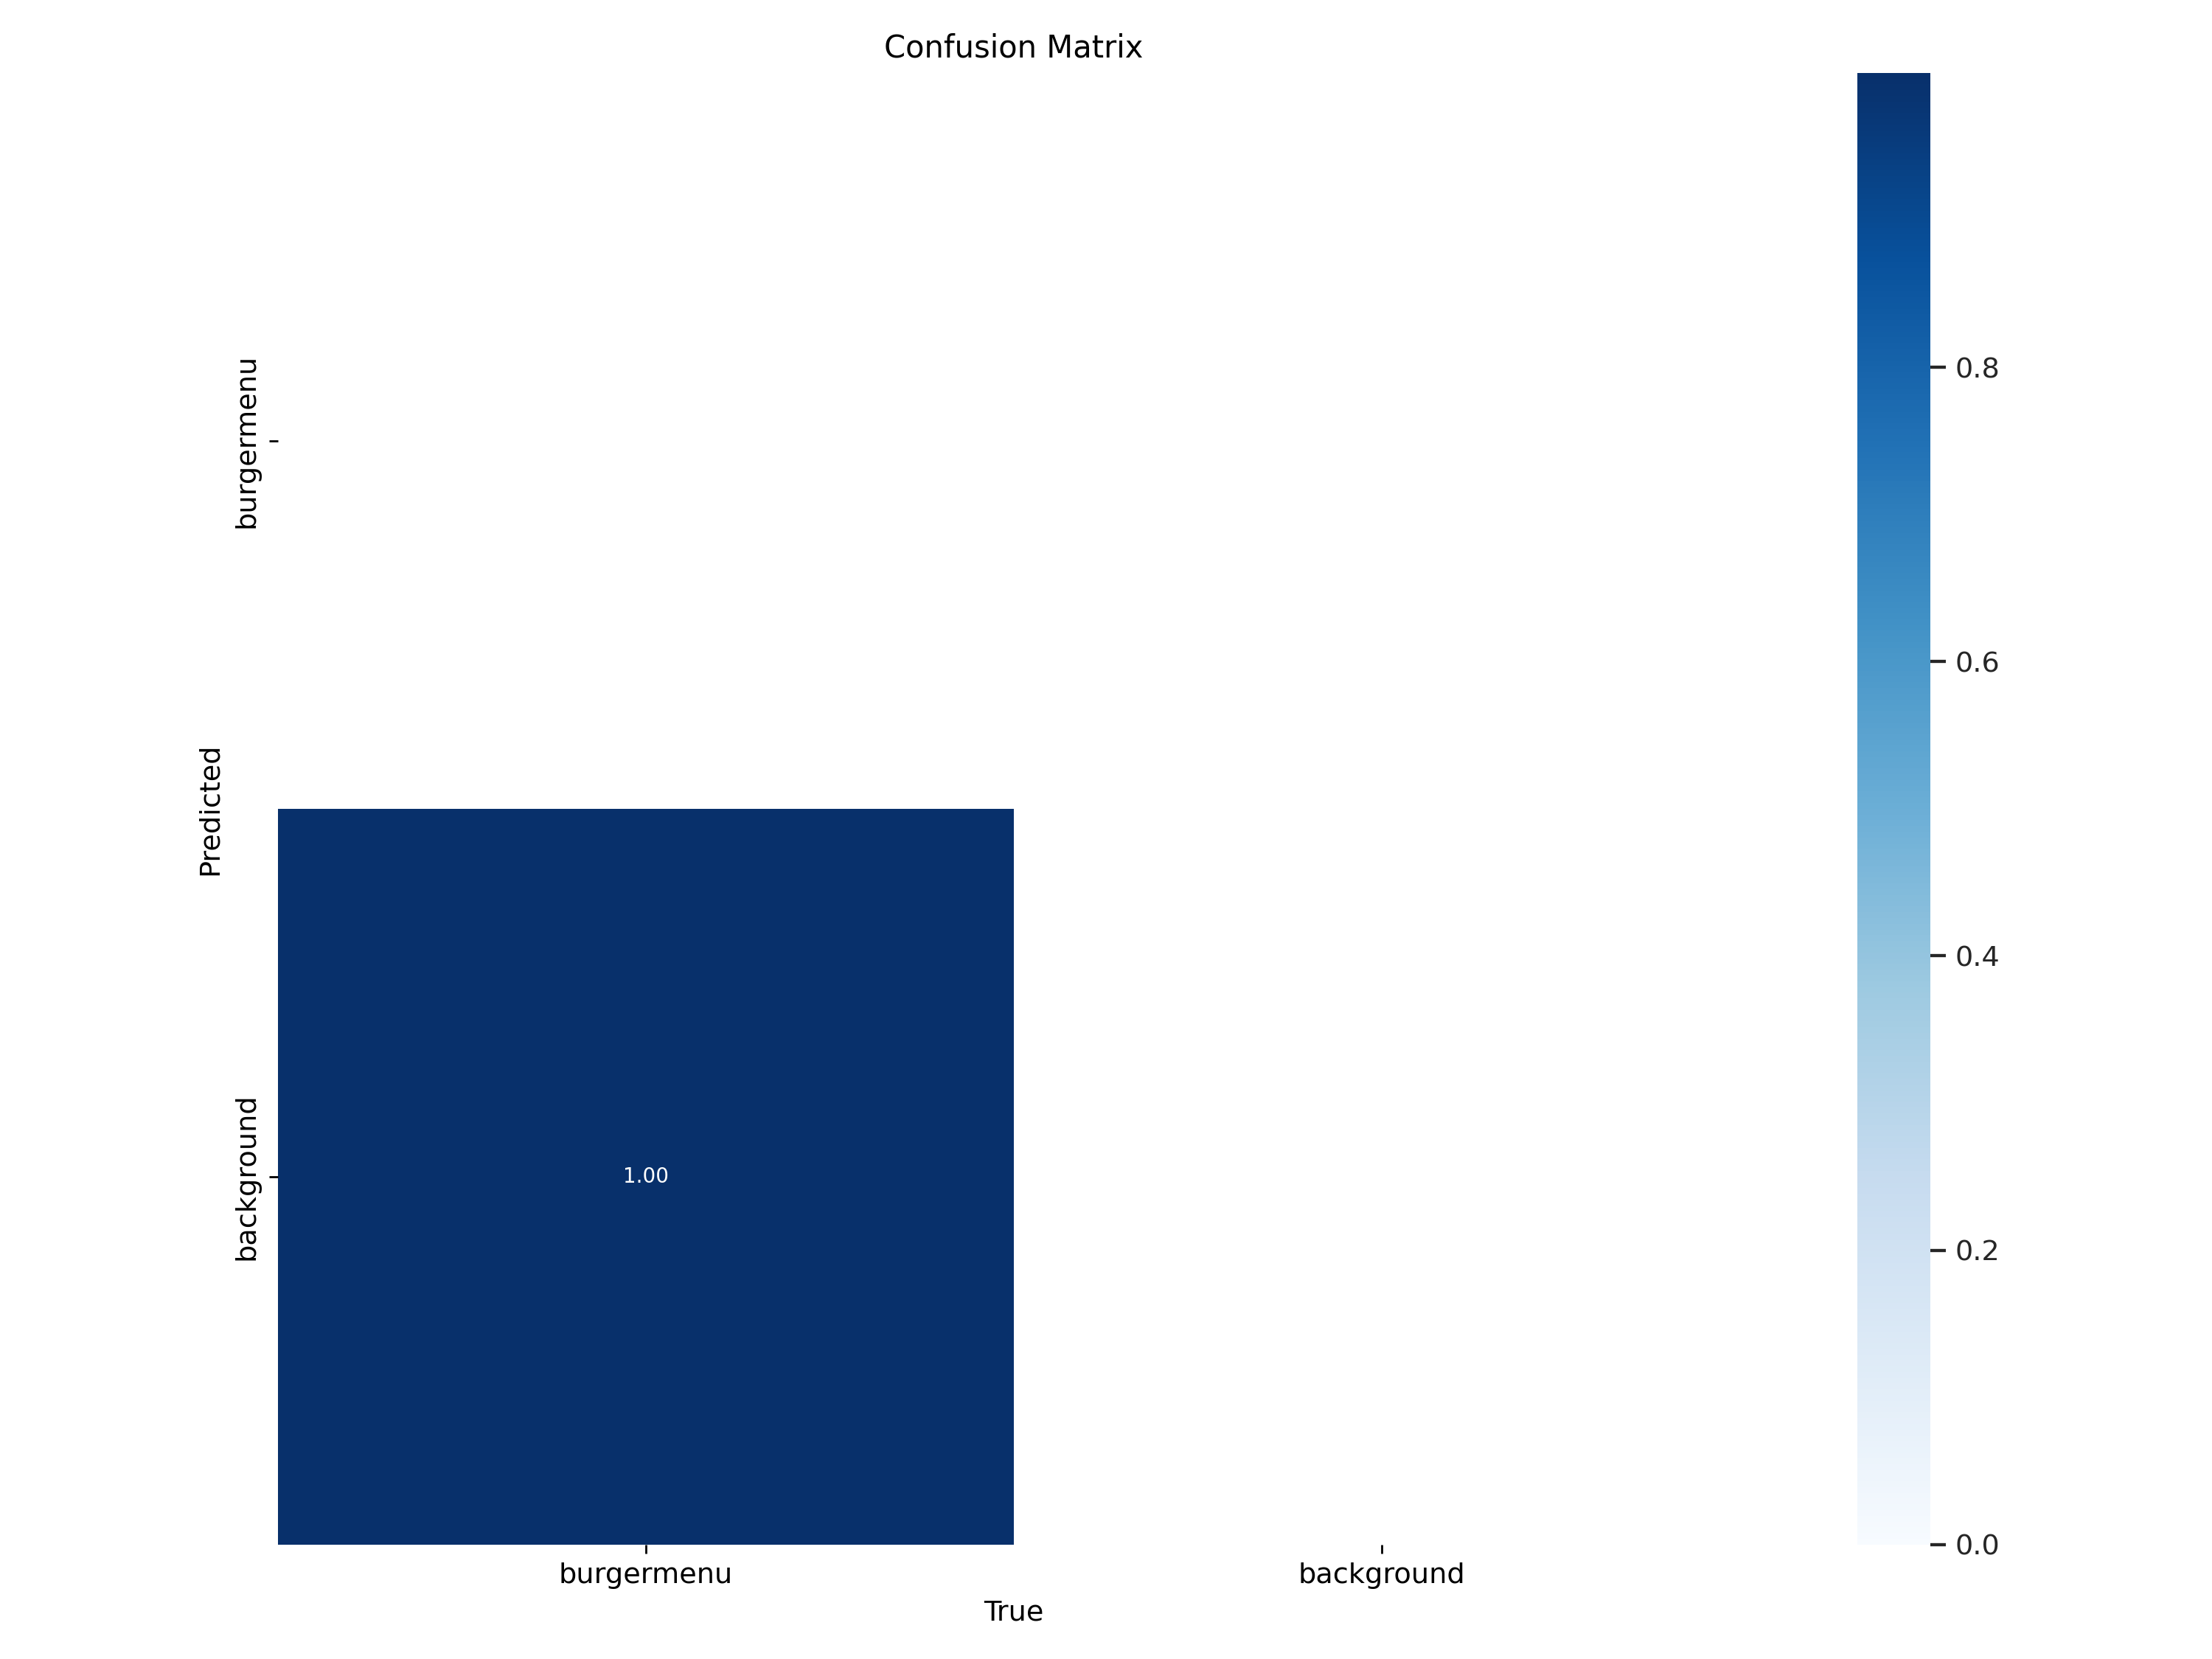

In [ ]:
Image.open("yolov5/runs/train/my_model_5x11/confusion_matrix.png")

In [ ]:
!ls yolov5/runs/detect/exp/

9LZ49471-cg.jpg  CO_YW2MllqY.jpg  MCYpwcrA56s.jpg
9ZRXQuQzJ8Y.jpg  e9QGiklTpFo.jpg  XqIMjZOQpyU.jpg
byoQQyJS5fo.jpg  g6DGBC-4bOI.jpg  YwFEoj_x6E4.jpg


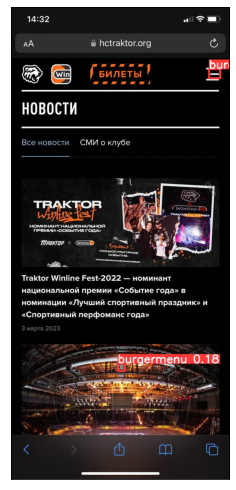

In [ ]:
pred_dir = './yolov5/runs/detect/exp4'
file_paths = []
flist = os.listdir(pred_dir)
for file in flist:
    fpath = os.path.join(pred_dir, file)
    file_paths.append(fpath)

plt.figure(figsize=(60, 40))
for i in range(1):
    random = np.random.randint(0, len(file_paths) - 1)
    plt.subplot(4, 4, i + 1)
    img_path = file_paths[random]
    img = plt.imread(img_path)
    plt.imshow(img)
    #plt.title('Predictions', size=10, color="black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()